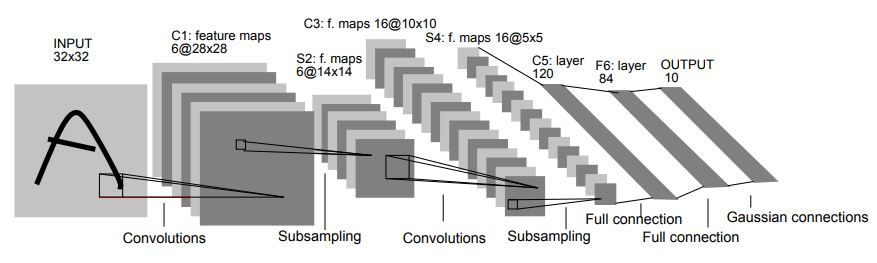

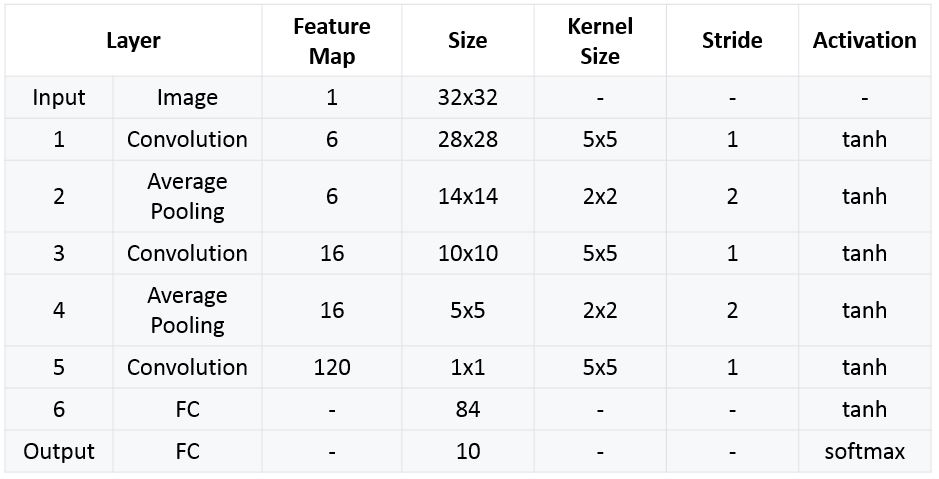

In [1]:
# Импорт библиотек
import os
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import random
import numpy as np
import pandas as pd
import tqdm
# Устанавливаем random seed'ы для воспроизводимости
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
# Скачиваем датасет MNIST (содержит рукописные цифры от 0 до 9 )
import torchvision.datasets

In [3]:
# Скачиваем датасет MNIST (содержит рукописные цифры от 0 до 9 )
sample = pd.read_csv('mnist_sample_submission.csv') # Образец посылки на kaggle
train_df = pd.read_csv('mnist_train.csv') # тренировочный датафрейм
test_df = pd.read_csv('mnist_test.csv')  # тестовый датафрейм для отправки на kaggle

print(f"Number of training samples: {len(train_df)}")
print("Any missing data? ", train_df.isnull().values.any())
print(f"Dataframe shape: {train_df.shape}")

Number of training samples: 42000
Any missing data?  False
Dataframe shape: (42000, 785)


In [4]:
X, y = train_df.drop(labels = 'label', axis=1), train_df['label']

In [5]:
# Разделяем датасет на тренировочную часть и на валидационную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
# Преобразуем DataFrame в Tensor
X_train = torch.tensor(X_train.values)
X_test = torch.tensor(X_test.values)
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)
test_df = torch.tensor(test_df.values)

In [7]:
# Посмотрим тип наших данных
X_train.dtype, y_train.dtype

(torch.int64, torch.int64)

In [8]:
# Преобразуем данные в дробные числа
X_train = X_train.float()
X_test = X_test.float()
test_df = test_df.float()

In [9]:
# Посмотрим на размерность датасета. Первое число - количество изображений, 2-е количество пикселей(28х28=784)
X_train.shape, X_test.shape

(torch.Size([33600, 784]), torch.Size([8400, 784]))

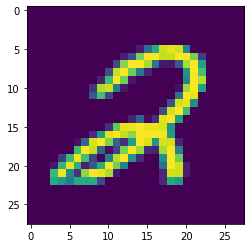

tensor(2)


In [10]:
# Посмотрим как выглядят числа с помощью библиотеки matplotlib
import matplotlib.pyplot as plt
plt.imshow(X_train.reshape(-1, 28, 28)[4,:,:])
plt.show()
print(y_train[4])


In [11]:
X_train.shape

torch.Size([33600, 784])

In [12]:
# Мы хотим переформатировать размерность до 1x28x28, u где 1 - это количество каналов
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)
test_df = test_df.reshape(-1, 1, 28, 28)

In [13]:
X_train.shape

torch.Size([33600, 1, 28, 28])

In [14]:
X_train.size(0)

33600

In [15]:
# Назовем нашу сверточную сеть LeNet5, т.к. в ней 5 слоев (2 свертки и 3 полносвязных слоя)
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2) # Свёрточный слой 1
        self.act1  = torch.nn.Tanh() # Функция активаци 1 - гиперболический тангенс
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2) # Пулинг 1
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0) # Свёрточный слой 2
        self.act2  = torch.nn.Tanh() # Функция активаци 2
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2) # Пулинг 2
    
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120) # Полносвязный слой 1
        self.act3  = torch.nn.Tanh()  # Функция активаци 3
        
        self.fc2   = torch.nn.Linear(120, 84) # Полносвязный слой 2
        self.act4  = torch.nn.Tanh() # Функция активаци 3
        
        self.fc3   = torch.nn.Linear(84, 10) # Полносвязный слой 3
        # После fc3 должна быть функция активации softmax, но здесь ее не пишем, так как она уже учитывается в лосс-функции
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [16]:
# Переведем вычисления на видеокарту
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [17]:
# Создаем лосс функцию - кроссэнтропия (софтмакс уже встроен в нее)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3) # Выбор метода оптимизации loss функции, в данном случае Adam

In [18]:
# Реализуем побатчевый градиентный спуск
batch_size = 100 # Размер батча

#test_accuracy_history = [] # можно сохранить оценки точности и значения лосс-функции для построения графиков 
#test_loss_history = []

X_test = X_test.to(device) # Переводим вычисления на видеокарту
y_test = y_test.to(device)

for epoch in range(10000): # Каждая эпоха - один проход по нашему тензору 
    order = np.random.permutation(len(X_train)) # Случайно перемешиваем датасет
    for start_index in range(0, len(X_train), batch_size): # Проход по одному батчу
        optimizer.zero_grad() # Обнуляем градиент перед каждой итерациец, т.к. в pytorch градиенты суммируются
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
   # test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
   # test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9661)
tensor(0.9724)
tensor(0.9798)
tensor(0.9844)
tensor(0.9839)
tensor(0.9845)
tensor(0.9845)
tensor(0.9823)
tensor(0.9873)
tensor(0.9851)
tensor(0.9851)
tensor(0.9860)
tensor(0.9857)
tensor(0.9876)
tensor(0.9869)
tensor(0.9862)
tensor(0.9892)
tensor(0.9856)
tensor(0.9850)
tensor(0.9870)
tensor(0.9888)
tensor(0.9876)
tensor(0.9879)
tensor(0.9848)
tensor(0.9846)
tensor(0.9869)
tensor(0.9881)
tensor(0.9873)
tensor(0.9882)
tensor(0.9881)
tensor(0.9887)
tensor(0.9888)
tensor(0.9888)
tensor(0.9888)
tensor(0.9756)
tensor(0.9868)
tensor(0.9867)
tensor(0.9874)
tensor(0.9881)
tensor(0.9875)
tensor(0.9883)
tensor(0.9883)
tensor(0.9886)
tensor(0.9883)
tensor(0.9885)
tensor(0.9883)
tensor(0.9882)
tensor(0.9886)
tensor(0.9885)
tensor(0.9886)
tensor(0.9887)
tensor(0.9883)
tensor(0.9883)
tensor(0.9885)
tensor(0.9886)
tensor(0.9890)
tensor(0.9883)
tensor(0.9886)
tensor(0.9886)


KeyboardInterrupt: 

In [20]:
#Cоздаем файл посылки для kaggle:
preds = lenet5.forward(test_df.to(device))
preds = preds.argmax(dim=1).cpu().numpy()
sample['Label'] = pd.DataFrame(preds)
sample.to_csv('submission_mnist_CNN.csv',index=False)
# Результат на kaggle - 0.98771